In [1]:
from pycalphad import Database, Model, calculate, equilibrium, variables as v
from xarray import DataArray

In [2]:
class PrecipitateModel(Model):
    matrix_chempots = []
    @property
    def matrix_hyperplane(self):
        return sum(self.moles(self.nonvacant_elements[i])*self.matrix_chempots[i]
                   for i in range(len(self.nonvacant_elements)))
    @property
    def GM(self):
        return self.ast - self.matrix_hyperplane

In [3]:
import numpy as np

def parallel_tangent(dbf, comps, matrix_phase, matrix_comp, precipitate_phase, temp):
    conds = {v.N: 1, v.P: 1e5, v.T: temp}
    conds.update(matrix_comp)
    matrix_eq = equilibrium(dbf, comps, matrix_phase, conds)
    # pycalphad currently doesn't have a way to turn global minimization off and directly specify starting points
    if matrix_eq.isel(vertex=1).Phase.values.flatten() != ['']:
        raise ValueError('Matrix phase has miscibility gap. This bug will be fixed in the future')
    matrix_chempots = matrix_eq.MU.values.flatten()
    # This part will not work until mass balance constraint can be relaxed
    #precip = PrecipitateModel(dbf, comps, precipitate_phase)
    #precip.matrix_chempots = matrix_chempots
    #conds = {v.N: 1, v.P: 1e5, v.T: temp}
    #df_eq = equilibrium(dbf, comps, precipitate_phase, conds, model=precip)
    df_eq = calculate(dbf, comps, precipitate_phase, T=temp, N=1, P=1e5)
    df_eq['GM'] = df_eq.X.values[0,0,0].dot(matrix_chempots) - df_eq.GM
    selected_idx = df_eq.GM.argmax()
    return matrix_eq.isel(vertex=0), df_eq.isel(points=selected_idx)

def nucleation_barrier(dbf, comps, matrix_phase, matrix_comp, precipitate_phase, temp,
                       interfacial_energy, precipitate_volume):
    "Spherical precipitate."
    matrix_eq, precip_eq = parallel_tangent(dbf, comps, matrix_phase, matrix_comp, precipitate_phase, temp)
    precip_driving_force = float(precip_eq.GM.values) # J/mol
    elastic_misfit_energy = 0 # J/mol
    barrier = 16./3 * interfacial_energy **3 / (precip_driving_force + elastic_misfit_energy) ** 2 # J/mol
    critical_radius = 2 * interfacial_energy / (precip_driving_force + elastic_misfit_energy) # m
    if critical_radius < 0:
        barrier = np.inf
    cluster_area = 4*np.pi*critical_radius**2
    cluster_volume = (4./3) * np.pi * critical_radius**3
    return barrier, precip_driving_force, cluster_area, cluster_volume, matrix_eq, precip_eq

def nucleation_rate(dbf, comps, matrix_phase, matrix_comp, precipitate_phase, temp):
    # Numbers here are made up for demonstration purposes
    interfacial_energy = 250e-3 # J/m^2
    precipitate_volume = 7.3e-6 # m^3/mol
    atomic_distance = 2e-10 # m
    n_prefactor = 1e21
    # Could retrieve from TDB in principle
    diffusivity = 2e-4 * np.exp(-142e3/(8.3145*temp)) # m^2 / s

    g_star, g_nucl, area, volume, matrix_eq, precip_eq = nucleation_barrier(dbf, comps, matrix_phase,
                                                                            matrix_comp, precipitate_phase,
                                                                            temp, interfacial_energy,
                                                                            precipitate_volume)

    zeldovich = 3 * (g_nucl ** 2) / (4*np.sqrt(np.pi*8.3145*temp) * ((area * interfacial_energy) ** (3./2))) # dim-less

    conc_diff = (precip_eq.X.values.flatten() - matrix_eq.X.values.flatten()) ** 2 /\
                (matrix_eq.X.values.flatten() * diffusivity)
    beta_attachment_rate = (area / ((atomic_distance**4) * precipitate_volume)) / conc_diff.sum()  # s^-1
    incubation_time = 1 / (2*beta_attachment_rate*zeldovich) # s
    ss_nucl_rate = n_prefactor * zeldovich * beta_attachment_rate * np.exp(-g_star/(8.3145*temp))
    return ss_nucl_rate, incubation_time

dbf = Database('Al-Cu-Zr_Zhou.tdb')
comps = ['AL', 'CU', 'VA']

temps = np.linspace(300, 1500, 30)
results = []
for temp in temps:
    result, incub_time = nucleation_rate(dbf, comps, 'BCC_A2', {v.X('CU'): 0.4}, 'AL2CU', temp)
    results.append(result)

Text(0.5, 0, 'Temperature (K)')

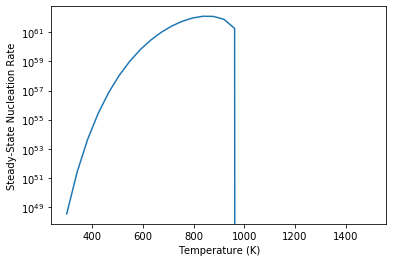

In [4]:
import matplotlib.pyplot as plt
plt.semilogy(temps, results)
plt.ylabel('Steady-State Nucleation Rate')
plt.xlabel('Temperature (K)')

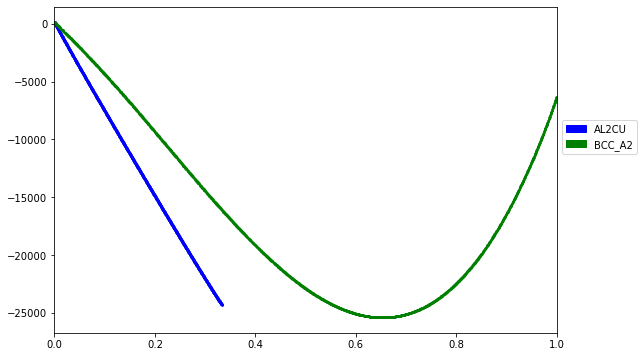

In [5]:
from pycalphad import calculate
import matplotlib.pyplot as plt
from pycalphad.plot.utils import phase_legend
import numpy as np

my_phases = ['AL2CU', 'BCC_A2']
legend_handles, colorlist = phase_legend(my_phases)

fig = plt.figure(figsize=(9,6))
ax = fig.gca()
for name in my_phases:
    result = calculate(dbf, ['AL', 'CU', 'VA'], name, P=101325, T=300, output='GM')
    ax.scatter(result.X.sel(component='CU'), result.GM,
               marker='.', s=5, color=colorlist[name.upper()])
ax.set_xlim((0, 1))
ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.6))
plt.show()